# Forward Kinematics for Wheeled Robots; Dead Reckoning

In [1]:
# Preparation
import numpy as np
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
import ipywidgets

Let's first setup useful functions (see transforms2d notebook)

In [2]:
def mktr(x, y):
    return np.array([[1, 0, x],
                     [0, 1, y],
                     [0, 0, 1]])


def mkrot(theta):
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                     [np.sin(theta),  np.cos(theta), 0],
                     [0,              0,             1]])


def drawf(f, ax=None, name=None):
    """ Draw frame defined by f on axis ax (if provided) or on plt.gca() otherwise """
    xhat = f @ np.array([[0, 0, 1], [1, 0, 1]]).T
    yhat = f @ np.array([[0, 0, 1], [0, 1, 1]]).T
    if(not ax):
        ax = plt.gca()
    ax.plot(xhat[0, :], xhat[1, :], 'r-')  # transformed x unit vector
    ax.plot(yhat[0, :], yhat[1, :], 'g-')  # transformed y unit vector
    if(name):
        ax.text(xhat[0, 0], xhat[1, 0], name, va="top", ha="center")

A function to draw a robot at a given pose `f`

In [3]:
def drawrobot(f, l, ax=None, alpha=0.5):
    """ Draw robot at f, with wheel distance from center l,
    on axis ax (if provided) or on plt.gca() otherwise.
    if l is None, no wheels are drawn"""

    if(not ax):
        ax = plt.gca()

    robot = ([[-1, 2, -1, -1],  # x
              [-1, 0,  1, -1]])  # y
    robot = np.array(robot)
    robot = np.vstack((
        robot * 0.1,  # scale by 0.1 units
        np.ones((1, robot.shape[1]))))

    robott = f @ robot

    wheell = np.array([
        [-0.05, 0.05],
        [l, l],
        [1, 1]
    ])
    wheelr = wheell * np.array([[1, -1, 1]]).T
    wheellt = f @ wheell
    wheelrt = f @ wheelr
    ax.plot(robott[0, :], robott[1, :], 'k-', alpha=alpha)
    ax.plot(wheellt[0, :], wheellt[1, :], 'k-', alpha=alpha)
    ax.plot(wheelrt[0, :], wheelrt[1, :], 'k-', alpha=alpha)

Note how the frame is centered in the middle point between the two wheels, and the robot points towards the $x$ axis.

(-0.15500000000000003, 1.055, -0.15500000000000003, 1.055)

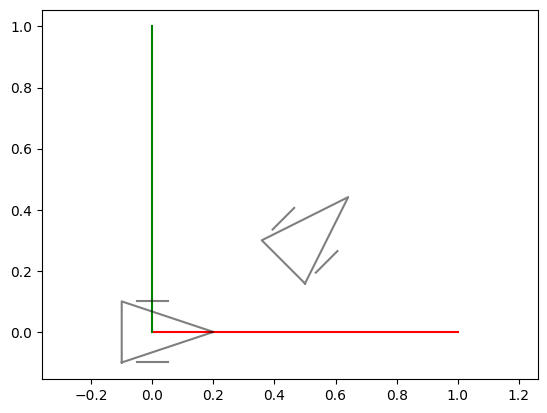

In [4]:
drawf(np.eye(3))
drawrobot(np.eye(3), 0.1)
drawrobot(mktr(0.5, 0.3) @ mkrot(np.pi/4), 0.1)
plt.gca().axis("equal")

## The kinematic model of a differential-drive robot
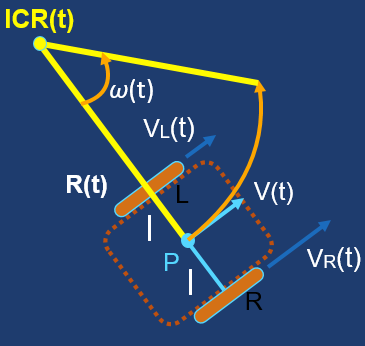

For a given differential drive robot, we have the following (fixed) parameter:
* $l$: distance from the robot frame to each wheel.  The distance between the wheel is therefore $2 \cdot l$

We control the angular speed of each wheel $\phi_L, \phi_R$. Given the wheel radius $r$, the tangential speed for each wheel is $v_L = r \phi_L$ and $v_R = r \phi_R$, respectively.  From now on, we assume we directly control (or measure) $v_L$ and $v_R$.

Assuming that $v_L$ and $v_R$ are constant during a short time interval $[t, t+\delta t]$, we have three ways to update the pose of the robot:
* Euler method
* Runge-Kutta method
* Exact method

The function below implements the exact method, and returns a transform from the pose at $t$ to the pose at $t+\delta t$.

In [5]:
def ddtr(vl, vr, l, dt):
    """ returns the pose transform for a motion with duration dt of a differential
    drive robot with wheel speeds vl and vr and wheelbase l """

    if(np.isclose(vl, vr)):  # we are moving straight, R is at the infinity and we handle this case separately
        return mktr((vr + vl)/2*dt, 0)  # note we translate along x ()

    omega = (vr - vl) / (2 * l)  # angular speed of the robot frame
    R = l * (vr + vl) / (vr - vl)

    # Make sure you understand this!
    return mktr(0, R) @ mkrot(omega * dt) @ mktr(0, -R)

Let's test our function.  Try special cases and try for each to predict where the ICR will be.
* $v_R = -v_L$
* $v_R = 0$, $v_L > 0$
* $v_R = 0.5 \cdot v_L$

In [6]:
l = 0.1
initial_frame = np.eye(3)  # try changing this


@ipywidgets.interact(vl=ipywidgets.FloatSlider(min=-2, max=+2),
                     vr=ipywidgets.FloatSlider(min=-2, max=+2))
def f(vl, vr):
    drawf(initial_frame)  # Initial frame
    f = ddtr(vl, vr, l, 1)
    drawf(f)
    drawrobot(f, l)
    plt.axis("equal")

interactive(children=(FloatSlider(value=0.0, description='vl', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…

This approach tells you how to move from the pose at $t$ to the pose at $t+\delta t$.  Then you can concatenate multiple transformations.

(-0.21015401827602195,
 2.2132343837964608,
 -0.5541103978880942,
 1.0740052570422902)

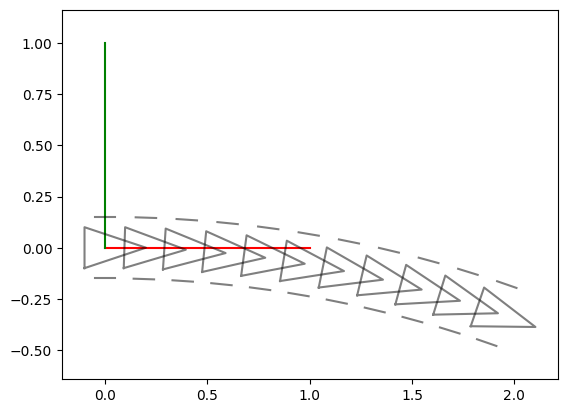

In [7]:
dt = 1.0
# dt is the time step
Ts = [np.eye(3)]
# Ts is a list of poses, initialized with the identity matrix

l = 0.15
vl, vr = 0.20, 0.19

for i in range(10):
    Ts.append(Ts[-1] @ ddtr(vl, vr, l, dt))
    
drawf(np.eye(3))
for T in Ts:
    drawrobot(T, l)
plt.axis("equal")

Question: in the example above, would you get the same result if you estimated the final position in a single step?  Try that, and make sure you understand the result.

In [8]:
@ipywidgets.interact(
    vl=ipywidgets.FloatSlider(min=-0.5, max=0.5,  value=0,    step=0.02),
    vr=ipywidgets.FloatSlider(min=-0.5, max=0.5,  value=0,    step=0.02),
    l= ipywidgets.FloatSlider(min=0.05, max=0.15, value=0.10, step=0.01))
def f(vl, vr, l):
    Ts = [np.eye(3)]

    for i in range(10):
        Ts.append(Ts[-1] @ ddtr(vl, vr, l, 1))

    drawf(np.eye(3))
    for T in Ts:
        drawrobot(T, l)
    plt.axis("equal")

interactive(children=(FloatSlider(value=0.0, description='vl', max=0.5, min=-0.5, step=0.02), FloatSlider(valu…

## Dead Reckoning for a differential drive robot
We now have all the necessary info in order to predict the trajectory when the wheel speeds change over time.  We define the initial and final speeds for the left and right wheels, and let them vary linearly from $t=0$ to $t=10$.

Can you set the parameters to get an s-shaped path?

Also try changing the value of `dt` and make sure you understand under what conditions the final pose of the robot changes when you change `dt`.

In [9]:
##### l = 0.05

@ipywidgets.interact(
    vl0=ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vr0=ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vl1=ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    vr1=ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0, step=0.02),
    dt=ipywidgets.Select(options=[1, 5]))
def f(vl0, vr0, vl1, vr1, dt):
    t0 = 0
    t1 = 10

    def wheelspeeds(t):
        return (vl0 + (vl1-vl0)*(t-t0)/(t1-t0),
                vr0 + (vr1-vr0)*(t-t0)/(t1-t0))

    ts = np.arange(t0, t1+dt, dt)
    vls, vrs = [], []
    for t in ts:
        vl, vr = wheelspeeds(t)
        vls.append(vl)
        vrs.append(vr)

    cT = np.eye(3)
    Ts = []
    for i, t in enumerate(ts):
        if(i == 0):
            Ts.append(cT)
        else:
            vl, vr = vls[i-1], vrs[i-1]
            cT = cT @ ddtr(vl, vr, l, dt)
            Ts.append(cT)

    fig, ax = plt.subplots()
    ax.plot(ts, vls, label=("left"))
    ax.plot(ts, vrs, label=("right"))
    ax.set(xlabel="time",
           ylabel="wheel tangential speed")
    ax.legend()

    fig, ax = plt.subplots()
    drawf(np.eye(3), ax=ax)
    for T in Ts:
        drawrobot(T, l, ax=ax)
    drawf(Ts[-1], name="time = {}".format(ts[-1]), ax=ax)
    plt.axis("equal")

interactive(children=(FloatSlider(value=0.0, description='vl0', max=0.5, min=-0.5, step=0.02), FloatSlider(val…

## Bicycle Kinematics

Implement the kinematic model of a steered robot (bicycle kinematics) with control inputs:
* steering angle $\gamma$
* tangential velocity of the back wheel $v$.

Note: the model depends on the wheelbase (distance $L$ between the front and back wheel).

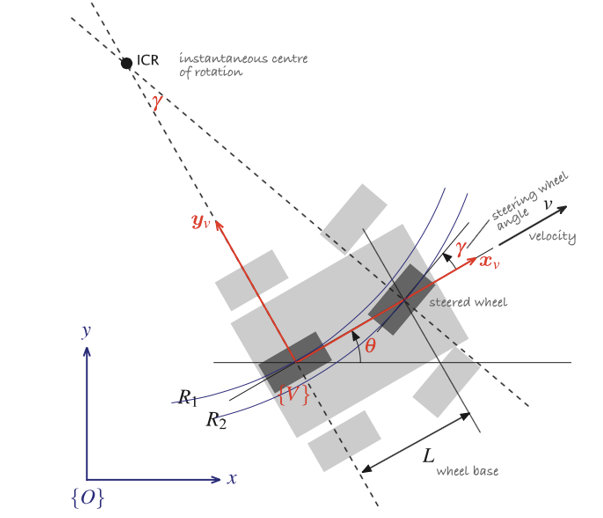

### Drawing the bicycle robot

In [10]:
def drawrobot_bicycle(f, gamma, L, ax = None, alpha = 0.5):
    """ Draw bicycle robot at pose f, with wheel distance L,
    on axis ax (if provided) or on plt.gca() otherwise. """
    
    if(not ax):
        ax = plt.gca()
    
    # This is the chassis of the robot, a thin arrow
    robot = ([[ 0  , 1  , 1  , 0  , 0  ],  # x
              [-0.3,-0.1, 0.1, 0.3,-0.3]]) # y 
    robot = np.array(robot)
    robot = np.vstack((
        robot * L, # scale by L units: back is center of the back wheel; tip is the center of the front wheel
        np.ones((1,robot.shape[1]))))
    # ... and now it's in homogeneous coordinates

    # define back and front wheels
    wheelb = np.array([
        [-L*0.3, +L*0.3], # wheel diameter does not matter. It's now 0.6*L
        [ 0,      0    ],
        [ 1,      1    ]
    ])    
    wheelf = mktr(L,0) @ mkrot(gamma) @ wheelb # make sure you understand this!
    
    # transform robot and both wheels
    robott = f @ robot
    wheelbt = f @ wheelb
    wheelft = f @ wheelf
    
    ax.plot(robott[0,:],robott[1,:],'k-',alpha=alpha)   # Draw the chassis
    ax.plot(wheelbt[0,:],wheelbt[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the back wheel
    ax.plot(wheelft[0,:],wheelft[1,:],'k-',alpha=alpha, linewidth = 2) # Draw the front wheel

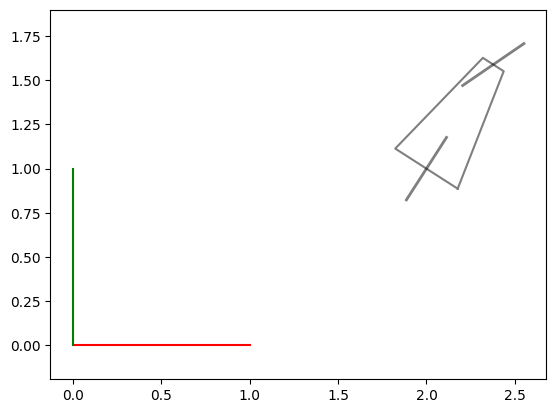

In [11]:
# Testing our drawing function
drawrobot_bicycle(mktr(2,1)@mkrot(1), gamma=-0.4, L=0.7)
drawf(mktr(0,0))
plt.axis("equal");

### Kinematic model of the bicycle robot

In [12]:
# Kinematic model of the bicycle robot
def bctr(v,gamma,L,dt):
    if(np.isclose(gamma,0)):
        return mktr(v*dt, 0)
    R = L/np.tan(gamma)
    omega = v/R
    return mktr(0,R) @ mkrot(omega*dt) @ mktr(0,-R)

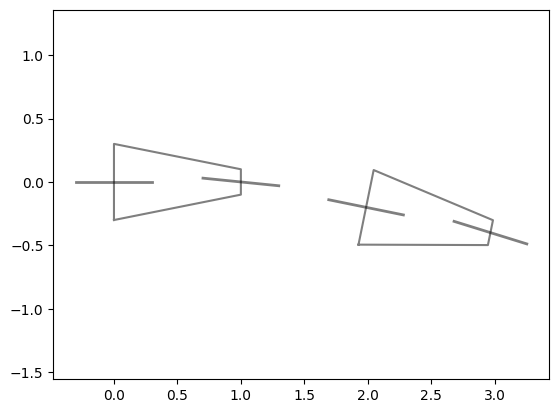

In [13]:
# Testing our kinematic model
gamma = -0.1
L = 1
initial_pose = mktr(0,0)
final_pose = initial_pose @ bctr(1,gamma,L,2)
drawrobot_bicycle(initial_pose, gamma, L)
drawrobot_bicycle(final_pose, gamma, L)
plt.axis("equal");

In [14]:
initial_frame = np.eye(3)
L = 1

@ipywidgets.interact(
    v = ipywidgets.FloatSlider(min=-2,max=+2),
    gamma = ipywidgets.FloatSlider(min=-np.pi/2,max=+np.pi/2,step=np.pi/20))
def f(v, gamma):
    drawf(initial_frame) # Initial frame
    f = bctr(v, gamma, L, 1)
    #drawf(f)
    drawrobot_bicycle(f, gamma, L)
    plt.axis("equal") 

interactive(children=(FloatSlider(value=0.0, description='v', max=2.0, min=-2.0), FloatSlider(value=0.0, descr…

### A simulator for the bicycle model

In [15]:
# Wrap everything in a simple robot simulator
class BCRobot:
    def __init__(self, initial_pose, L):
        self.pose = initial_pose # will always store the current pose
        self.L = L
        
    def step(self, v, gamma, dt):
        self.pose = self.pose @ bctr(v, gamma, self.L, dt) # this is where the magic happens
        return self.pose
    
    def getxy(self):
        return self.pose[0:2,2] # extracts [x,y] from current pose
    
    def gettheta(self): # sin(theta)      cos(theta)
        return np.arctan2(self.pose[1,0], self.pose[0,0])

### Using the simulator for forward kinematics

Draw the trajectory of a robot with a constant $v$ and a $\gamma$ value that changes with time according to the following law:

* Constant $v$
* Cycle forever:
    * 2 seconds straight ($\gamma = 0$)
    * 10 seconds slight left ($\gamma = 5$ degrees)
    * 5 seconds slight right ($\gamma = -5$ degrees)

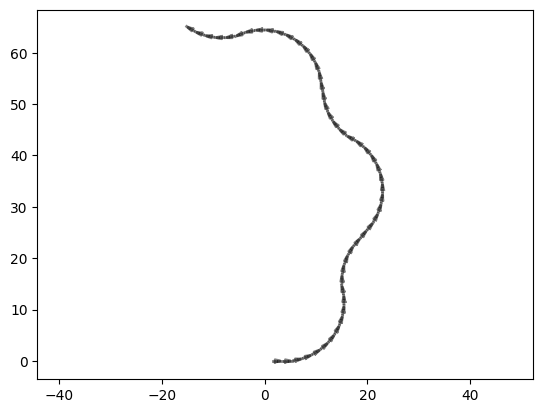

In [16]:
L = 1
robot = BCRobot(np.eye(3), L = L)

# Implementation of law 1
v = 2
for j in range(3):
    for i in range(2):
        gamma = 0
        robot.step(v = v, gamma = gamma, dt = 1)
        drawrobot_bicycle(robot.pose, gamma, robot.L)
    for i in range(10):
        gamma = np.deg2rad(5)
        robot.step(v = v, gamma = gamma, dt = 1)
        drawrobot_bicycle(robot.pose, gamma, robot.L)
    for i in range(5):
        gamma = np.deg2rad(-5)
        robot.step(v = v, gamma = gamma, dt = 1)
        drawrobot_bicycle(robot.pose, gamma, robot.L)
plt.axis("equal");

### Exercise

Implement the same, for the following motion law:
* Constant $v$
* $\gamma(t) = t / 2$ degrees on the interval $t \in [0, 20]$ seconds.